### Project description

The project is about predicting the number of recommendations of a comment performed on New York Times Comments
dataset that can be found under the link https://www.kaggle.com/datasets/aashita/nyt-comments.
Main challanges of this project are:
* handling large data volume
* feature engineering
* etc..
To 

### Imports

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
import pandas as pd

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local[8]").setAppName("big_data")
sc = SparkContext.getOrCreate(conf=conf)

22/06/25 19:08:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark = SparkSession.builder.getOrCreate()

### Reading data

In [4]:
def read_spark_df(path):
    return spark.read.option("multiline",True).option('lineSep','\n').option("header", True).option("delimiter", ",").option("inferSchema",True).option("escapeQuotes", True).option("quote", "\"").option("escape", "\"").csv(path)

In [5]:
articles_df = read_spark_df('data/nyt-articles-2020.csv')


comments_df = read_spark_df('data/nyt-comments-2020.csv')

In [6]:
articles_df.printSchema()

root
 |-- newsdesk: string (nullable = true)
 |-- section: string (nullable = true)
 |-- subsection: string (nullable = true)
 |-- material: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- pub_date: string (nullable = true)
 |-- n_comments: integer (nullable = true)
: string (nullable = true)



In [7]:
comments_df = comments_df.limit(1000)

In [8]:
df = comments_df.withColumn("updateDate", comments_df['updateDate'].cast(DateType()))

In [9]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: string (nullable = true)
 |-- updateDate: string (nullable = true)
 |-- approveDate: string (nullable = true)
 |-- recommendations: integer (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: boolean (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: boolean (nullable = true)
 |-- articleID: string (nullable = true)


We can observe that although we used inferSchema some of the columns should be stored as a different data type. Let's fix it.

In [10]:
comments_df=comments_df.withColumn('recommendations',comments_df['recommendations'].cast("float"))\
                        .withColumn("createDate", comments_df['createDate'].cast(DateType()))\
                        .withColumn("updateDate", comments_df['updateDate'].cast(DateType()))\
                        .withColumn("approveDate", comments_df['approveDate'].cast(DateType()))\
                        .withColumn('replyCount',comments_df['replyCount'].cast("int"))\
                        .withColumn('depth',comments_df['depth'].cast("int"))\
                        .withColumn('isAnonymous',comments_df['isAnonymous'].cast("int"))\
                        .withColumn('editorsSelection',comments_df['editorsSelection'].cast("int"))
#actually some of the above columns are boolean but pyspark does not provide such datatype so we cast them to int

In [11]:
articles_df = articles_df.withColumn('word_count',articles_df['word_count'].cast("int"))\
                         .withColumn("pub_date", articles_df['pub_date'].cast(DateType()))\
                         .withColumn('n_comments',articles_df['n_comments'].cast("int"))

In [12]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: date (nullable = true)
 |-- updateDate: date (nullable = true)
 |-- approveDate: date (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: integer (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: integer (nullable = true)
 |-- articleID: string (nullable = true)



In [13]:
articles_df.printSchema()

root
 |-- newsdesk: string (nullable = true)
 |-- section: string (nullable = true)
 |-- subsection: string (nullable = true)
 |-- material: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- pub_date: date (nullable = true)
 |-- n_comments: integer (nullable = true)
: string (nullable = true)



Let's take a look at our target variable

In [14]:
comments_df.describe(['recommendations']).show()

+-------+-----------------+
|summary|  recommendations|
+-------+-----------------+
|  count|             1000|
|   mean|           11.986|
| stddev|27.61623545055446|
|    min|              0.0|
|    max|            402.0|
+-------+-----------------+



We can observe that data is contains outliers. We will get rid of them using quantiles.

In [15]:
upper_limit = comments_df.approxQuantile('recommendations', [ 0.9], 0.05)[0]

In [16]:
comments_df = comments_df.filter((col('recommendations')<upper_limit))

In [17]:
comments_df.describe(['recommendations']).show()

+-------+-----------------+
|summary|  recommendations|
+-------+-----------------+
|  count|              852|
|   mean|4.772300469483568|
| stddev|5.022607677901019|
|    min|              0.0|
|    max|             20.0|
+-------+-----------------+



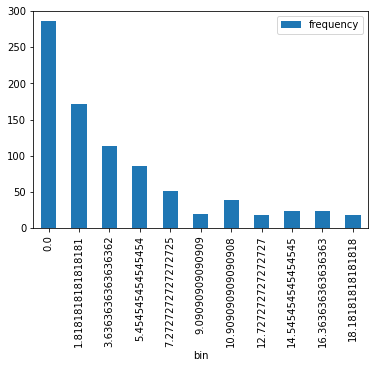

In [18]:
gre_histogram = comments_df.select('recommendations').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

Transformr text to vectors

In [19]:
from pyspark.ml.feature import StopWordsRemover,Word2Vec
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [20]:
comments_df=comments_df.withColumn("createDateInt", F.unix_timestamp(comments_df['createDate']))

aritcles_data = articles_df.select(col("abstract"),col("pub_date"),
                          col("keywords"),
                          col("uniqueID\r").alias('articleID'))
aritcles_data = aritcles_data.withColumn("pubDateInt", F.unix_timestamp(col('pub_date'))).drop('pub_date')
# aritcles_data = aritcles_data.filter(~ col('abstract').isNull()) # TODO: nie wywalać tylko uzpełniać średnią wartośćią z wek

In [21]:
articles_df.show()

+--------------+------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+----------+----------+--------------------+
|
+--------------+------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+----------+----------+--------------------+
|     Editorial|           Opinion|       null|          Editorial|Protect Veterans ...|Congress could do...|['Veterans', 'For...|       680|2020-01-01|       186|nyt://article/69a...|
|         Games|Crosswords & Games|       null|               News|‘It’s Green and S...|Christina Iverson...|['Crossword Puzzl...|       931|2020-01-01|       257|nyt://article/9ed...|
|       Science|           Science|       null|               News|Meteor Showers in...|All year long, Ea...|['Meteors and Met...|      1057|2020-01-01|         6|nyt://article/04b...|
|       Science|           Science|       null|Interactive Feature|Sync y

In [22]:
aritcles_data.show()

+--------------------+--------------------+--------------------+----------+
|            abstract|            keywords|           articleID|pubDateInt|
+--------------------+--------------------+--------------------+----------+
|Congress could do...|['Veterans', 'For...|nyt://article/69a...|1577833200|
|Christina Iverson...|['Crossword Puzzl...|nyt://article/9ed...|1577833200|
|All year long, Ea...|['Meteors and Met...|nyt://article/04b...|1577833200|
|Never miss an ecl...|['Space and Astro...|nyt://interactive...|1577833200|
|A year full of hi...|['Space and Astro...|nyt://article/bd8...|1577833200|
|Iran’s ability to...|['Iraq', 'Iran', ...|nyt://article/ac7...|1577833200|
|If you brother-in...|['Comedy and Humor']|nyt://article/dea...|1577833200|
|After the 67-year...|['Stroke', 'Brain...|nyt://article/dfd...|1577833200|
|Tangy and juicy, ...|['Cooking and Coo...|nyt://article/622...|1577833200|
|David Shariatmada...|["Don't Believe a...|nyt://article/7d9...|1577833200|
|Intermitten

In [23]:
from  pyspark.ml.linalg import DenseVector 

In [24]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.stat import Summarizer

In [25]:
def get_vector(df,column='commentBody',leave_columns =["commentID"]):
    df_without_nulls = df.filter(~ col(column).isNull())
    df_with_nulls = df.filter(col(column).isNull()).drop(column)
    df_without_nulls = df_without_nulls.withColumn(column, trim(regexp_replace(column,'(@\w+)|[^a-zA-Z\s]', '')))
    df_without_nulls = df_without_nulls.select(*leave_columns,split(col(column)," ").alias(column))
    remover = StopWordsRemover(inputCol=column, outputCol="filtered")
    filtered = remover.transform(df_without_nulls)
    word2vec = Word2Vec(inputCol="filtered", outputCol=f"feature_{column}")
    model = word2vec.fit(filtered)
    vectorized = model.transform(filtered)
    vectorized = vectorized.drop("filtered",column)
    if df_with_nulls.count() > 0:
        df_with_nulls = df_with_nulls.withColumn(f"feature_{column}",lit(None))
        mean_vector = vectorized.agg(Summarizer.mean(vectorized[f"feature_{column}"])).collect()[0][f'mean(feature_{column})']
        fill_with_mean_vector = udf(lambda: DenseVector(mean_vector.tolist()), VectorUDT())
        df_with_nulls = df_with_nulls.withColumn(f"feature_{column}", fill_with_mean_vector())
        vectorized = df_with_nulls.unionByName(vectorized)
    return vectorized

In [26]:
def vectorize_cols(df, columns, leave_columns):
    leave_columns = set(leave_columns).union(set(columns))
    df_out = None
    for c in columns:
        df_temp = get_vector(df, column=c, leave_columns = list(leave_columns.difference(set([c]))))
        df_temp = df_temp.withColumn("articleID", regexp_replace('articleID', '\r', ''))
        if df_out is None:
            df_out = df_temp
        else:
            unique_columns = list(set(df_temp.columns).difference(set(df_out.columns)))
            df_out = df_out.join(df_temp.select('articleID',*unique_columns), on='articleID', how='inner')
            
    return df_out.drop(*columns)

In [27]:
comments_df_leave_columns = ['commentID','createDateInt','recommendations','articleID','replyCount']
df = vectorize_cols(comments_df,columns=['commentBody'],leave_columns=comments_df_leave_columns)
df2 = vectorize_cols(aritcles_data,columns=['abstract','keywords'],leave_columns=aritcles_data.columns)

22/06/25 19:08:48 WARN StopWordsRemover: Default locale set was [en_PL]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
22/06/25 19:08:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/06/25 19:08:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/06/25 19:08:49 WARN StopWordsRemover: Default locale set was [en_PL]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
22/06/25 19:08:53 WARN StopWordsRemover: Default locale set was [en_PL]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [28]:
df.show()
df2.show()

+-------------+---------+---------------+--------------------+----------+--------------------+
|createDateInt|commentID|recommendations|           articleID|replyCount| feature_commentBody|
+-------------+---------+---------------+--------------------+----------+--------------------+
|   1577833200|104387472|            7.0|nyt://article/69a...|         5|[-0.0168700660837...|
|   1577833200|104387873|           17.0|nyt://article/69a...|         0|[-0.0272951105632...|
|   1577833200|104387976|            8.0|nyt://article/69a...|         0|[-0.0068847438320...|
|   1577833200|104390628|            1.0|nyt://article/69a...|         0|[-0.0108948359804...|
|   1577833200|104391463|            1.0|nyt://article/69a...|         0|[-0.0212304528077...|
|   1577833200|104392390|            0.0|nyt://article/69a...|         0|[-0.0105680347346...|
|   1577833200|104387855|            7.0|nyt://article/69a...|         0|[-0.0018281377851...|
|   1577833200|104388656|           10.0|nyt://art

In [29]:
df = df.withColumn("articleID", regexp_replace('articleID', '\r', ''))
df2 = df2.withColumn("articleID", regexp_replace('articleID', '\r', ''))

In [30]:
full_df = df.join(df2,on='articleID',how='inner')

In [31]:
from pyspark.sql.types import DoubleType

In [32]:
full_df = full_df.withColumn('time_passed', abs(full_df['pubDateInt'] - full_df['createDateInt']).cast(DoubleType()))
full_df = full_df.drop('pubDateInt','createDateInt')

In [33]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [34]:
def standarize_num_column(df,columns=['time_passed']):
    for column in columns:
        df = VectorAssembler(
          inputCols=[column], outputCol=f"{column}_vector"
        ).transform(df)

        df = StandardScaler(
              inputCol=f"{column}_vector", outputCol=f"scaled_{column}",
              withStd=True, withMean=False
            ).fit(df).transform(df)
        df = df.drop(f"{column}_vector",column)
    return df

In [35]:
full_df = standarize_num_column(full_df,['time_passed','replyCount'])

In [36]:
full_df.printSchema()

root
 |-- articleID: string (nullable = true)
 |-- commentID: integer (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- feature_commentBody: vector (nullable = true)
 |-- feature_abstract: vector (nullable = true)
 |-- feature_keywords: vector (nullable = true)
 |-- scaled_time_passed: vector (nullable = true)
 |-- scaled_replyCount: vector (nullable = true)



In [37]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['feature_abstract', 'feature_commentBody','feature_keywords','scaled_time_passed','scaled_replyCount']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
full_df = assembler.transform(full_df).drop(*numericCols)

In [38]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 6, 12, 18, float('Inf') ],inputCol="recommendations", outputCol="buckets")
full_df = bucketizer.setHandleInvalid("keep").transform(full_df)

In [39]:
full_df.printSchema()

root
 |-- articleID: string (nullable = true)
 |-- commentID: integer (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- features: vector (nullable = true)
 |-- buckets: double (nullable = true)



In [40]:
#### TODO ####

# from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.linalg import Vectors, VectorUDT
# from pyspark.sql.functions import udf, array

# mat = RowMatrix(full_df.select('features'))
# pc = mat.computePrincipalComponents(10)
# projected = mat.multiply(pc)

In [41]:
from pyspark.ml.feature import PCA

pca = PCA(k=30, inputCol="features")
pca.setOutputCol("pca_features")
df = pca.fit(full_df).transform(full_df)
df = df.drop('features').withColumn('features',col('pca_features'))
df.printSchema()

22/06/25 19:09:02 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/06/25 19:09:02 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


root
 |-- articleID: string (nullable = true)
 |-- commentID: integer (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- buckets: double (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [42]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = df

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="buckets", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="buckets", featuresCol="indexedFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "buckets", "features").show(15)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="buckets", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-------+--------------------+
|predictedLabel|buckets|            features|
+--------------+-------+--------------------+
|           0.0|    1.0|[0.24138544553394...|
|           0.0|    2.0|[0.24130585726171...|
|           0.0|    1.0|[0.24064529996499...|
|           1.0|    0.0|[-0.0760150297574...|
|           1.0|    1.0|[-0.0768987026052...|
|           1.0|    0.0|[0.22075581893359...|
|           2.0|    1.0|[0.00887913634709...|
|           0.0|    0.0|[0.00943497504472...|
|           0.0|    0.0|[0.00918091160304...|
|           0.0|    2.0|[0.00939770954939...|
|           1.0|    0.0|[0.00714019600292...|
|           0.0|    1.0|[0.00774020249022...|
|           0.0|    0.0|[0.00777205477766...|
|           0.0|    1.0|[0.00830571568021...|
|           1.0|    2.0|[0.00697942290259...|
+--------------+-------+--------------------+
only showing top 15 rows

Test Error = 0.341463
RandomForestClassificationModel: uid=RandomForestClassifier_f2adf8c646b2, numT